A short check whether the [blocking of internet connections from and to the Islamic Republic of Iran](https://en.wikipedia.org/wiki/2019_Internet_blackout_in_Iran) had an impact on the data of the November 2019 crawl (CC-MAIN-2019-47).

First, extract per-hour page counts for the `.ir` top-level domain and a couple of reference domains (`.mx`, `.lt`, `.me`, `.pt`) of similar size to exclude global network or crawler issues. Capture time stamps are in seconds, the [Presto date and time functions](https://prestodb.io/docs/current/functions/datetime.html) are used to aggregate the counts by hour.

```sql
SELECT date_trunc('hour', fetch_time) as capture_time,
       url_host_tld,
       COUNT(*) as count
FROM "ccindex"."ccindex"
WHERE crawl = 'CC-MAIN-2019-47'
  AND subset = 'warc'
  AND contains(ARRAY['ir', 'pt', 'lt', 'me', 'mx'], url_host_tld)
GROUP BY url_host_tld, date_trunc('hour', fetch_time)
ORDER BY date_trunc('hour', fetch_time)
```

Let's inspect the extracted data

In [1]:
import pandas as pd

df = pd.read_csv('data/net-block-ir-cc-main-2019-47-tlds.csv',
                  parse_dates=True, index_col='capture_time')
df = df.to_period(freq='H')
df.head(6)

,url_host_tld,count
capture_time,,
2019-11-11 19:00,pt,16928
2019-11-11 19:00,me,21923
2019-11-11 19:00,lt,20509
2019-11-11 19:00,mx,15274
2019-11-11 19:00,ir,20540
2019-11-11 20:00,me,35696


and try a first plot only for the counts of the `.ir` top-level domain

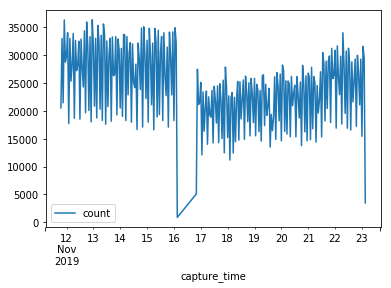

In [3]:
df[df['url_host_tld'] == 'ir'].plot()

Immediately visible are that the page counts per hour are bouncing up and down in a certain range. This is an artifact of the crawler: pages are fetched in batches (aka. "segments") and one segment is fetched in 2-3 hours with a higher throughput at the in the first 1-2 hours. To reduce the noise in the plot we smooth taking the average over a rolling window.

Also, for a couple of hours there are no pages fetched. The Common Crawler runs on AWS EC2 spot instances and sometimes it happens that the entire cluster gets lost. This happened on Nov 16 and consequently zero pages have been captured at this time. We add the missing data points with zero value.

Finally, we compare the captures per hour for the `.ir` TLD with other TLDs of similar counts. This allows to sort out other artifacts caused by crawler hard and software but not related to events in the real world.

Putting everything together:

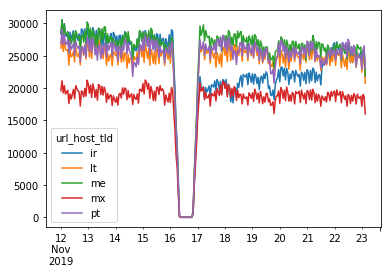

In [4]:
idx = pd.period_range(min(df.index), max(df.index), freq='H')
pivot = df.reset_index().pivot(index='capture_time', columns='url_host_tld', values='count') \
    .reindex(index=idx, fill_value=0)
pivot.rolling(6).mean().plot()

Clearly visible, the amount of page captures from the `.ir` TLD dropped by 20-30% between Nov 16 and Nov 21. However, most of the domains still served content. 

## Impact on Farsi Content

Next we'll have a look at page content in the [Farsi language](https://en.wikipedia.org/wiki/Persian_language), spoken in Iran, Afghanistan and Tajikistan. The ISO 639-3 code of Farsi is `fas` and we compare the counts with Greek (`ell`), Rumanian (`ron`), Hungarian (`hun`), Arabic (`ara`), Danish (`dan`) and Finnish (`fin`). 

The procedure is essentially the same as for the TLD counts:

```sql
SELECT date_trunc('hour', fetch_time) as capture_time,
       content_languages,
       COUNT(*) as count
FROM "ccindex"."ccindex"
WHERE crawl = 'CC-MAIN-2019-47'
  AND subset = 'warc'
  AND contains(ARRAY['fas', 'ell', 'ron', 'hun', 'ara', 'dan', 'fin'], content_languages)
GROUP BY content_languages, date_trunc('hour', fetch_time)
ORDER BY date_trunc('hour', fetch_time)
```

In [5]:
dfl = pd.read_csv('data/net-block-ir-cc-main-2019-47-languages.csv',
                  parse_dates=True, index_col='capture_time')
dfl = dfl.to_period(freq='H')
dfl.head(8)

,content_languages,count
capture_time,,
2019-11-11 19:00,ron,23445
2019-11-11 19:00,fin,21460
2019-11-11 19:00,ell,13707
2019-11-11 19:00,dan,20603
2019-11-11 19:00,fas,28197
2019-11-11 19:00,ara,22174
2019-11-11 19:00,hun,29202
2019-11-11 20:00,hun,47997


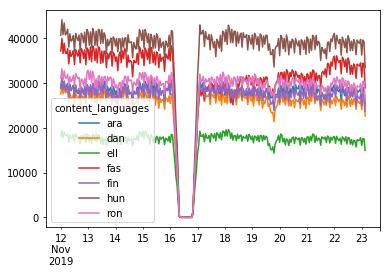

In [6]:
idx = pd.period_range(min(dfl.index), max(dfl.index), freq='H')
pivot = dfl.reset_index().pivot(index='capture_time', columns='content_languages', values='count') \
    .reindex(index=idx, fill_value=0)
pivot.rolling(6).mean().plot()

Again, same for Farsi content languages as for the `.ir` TLD: a visible but small drop in the number of page captures.